In [1]:
# import sys
# !{sys.executable} -m pip install pandas numpy scikit-learn matplotlib rdkit mordred -q

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.rdmolops import SanitizeMol
from mordred import Calculator, descriptors
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

print("Libraries imported successfully")

Libraries imported successfully


In [ ]:
from rdkit import Chem

filename = "challenge_data_1.csv"
standardized_filename = "standardized_"+filename
imputed_filename= "imputed_"+filename
training_filename="imputed_AqSolDB.csv"
trained_model="svm_solubility_model.pkl"
image_name = filename.split(".")[0] + "_prediction.png"




# Step 2 — load dataset
df = pd.read_csv(filename)
df.head()

,SMILES,LogS
0,COc1ccc(Cl)c(Nc2ncnc3cc(OCCN4CCN(C(C)=O)CC4)cc...,-4.369572
1,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,-4.159894
2,N#CC1(NC(=O)[C@@H]2CCCC[C@H]2C(=O)N2CCc3[nH]c4...,-4.130182
3,CN(C)C(=N)c1ccc(C(=O)N2CCN(S(=O)(=O)c3ccc4cc(B...,-2.879986
4,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,-4.449772


In [4]:
from rdkit.Chem.rdmolops import SanitizeMol
valid_smiles = []
valid_logs = []
for i, row in df.iterrows():
    smi = row['SMILES']
    logS = row['LogS']
    mol = Chem.MolFromSmiles(smi)
    
    if mol is not None:
        try:
            # Sanitize molecule (check valence, aromaticity, conjugation, hybridization)
            SanitizeMol(mol)
            
            # Canonicalize SMILES to have consistent representation
            clean_smi = Chem.MolToSmiles(mol, canonical=True)
            
            valid_smiles.append(clean_smi)
            valid_logs.append(logS)
        
        except Exception as e:
            # Skip molecules that fail sanitization
            continue

# Create a cleaned DataFrame
clean_df = pd.DataFrame({'SMILES': valid_smiles, 'LogS': valid_logs})

print(f"✅ Valid molecules after sanitization: {len(clean_df)} / {len(df)}")
clean_df.head()

✅ Valid molecules after sanitization: 1763 / 1763


,SMILES,LogS
0,COc1ccc(Cl)c(Nc2ncnc3cc(OCCN4CCN(C(C)=O)CC4)cc...,-4.369572
1,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,-4.159894
2,N#CC1(NC(=O)[C@@H]2CCCC[C@H]2C(=O)N2CCc3[nH]c4...,-4.130182
3,CN(C)C(=N)c1ccc(C(=O)N2CCN(S(=O)(=O)c3ccc4cc(B...,-2.879986
4,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,-4.449772


In [5]:
from rdkit.Chem.MolStandardize import rdMolStandardize

def standardize_molecule(mol):
    try:
        # Remove salts and fragments
        cleaner = rdMolStandardize.Cleanup(mol)
        # Normalize functional groups
        normalizer = rdMolStandardize.Normalize(cleaner)
        # Reionize to standard charge states
        reionizer = rdMolStandardize.Reionize(normalizer)
        return reionizer
    except:
        return mol  # return original if fails




In [6]:
standardized_smiles = []

for smi in df['SMILES']:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mol = standardize_molecule(mol)
        clean_smi = Chem.MolToSmiles(mol, canonical=True)
        standardized_smiles.append(clean_smi)
    else:
        standardized_smiles.append(None)

df['Standardized_SMILES'] = standardized_smiles
df = df.dropna(subset=['Standardized_SMILES']).reset_index(drop=True)

df.to_csv(standardized_filename, index=False)
print(f" Standardized dataset saved with {len(df)} molecules")
df.head()

[12:35:01] Initializing MetalDisconnector
[12:35:01] Running MetalDisconnector
[12:35:01] Initializing Normalizer
[12:35:01] Running Normalizer
[12:35:01] Initializing Normalizer
[12:35:01] Running Normalizer
[12:35:01] Initializing MetalDisconnector
[12:35:01] Running MetalDisconnector
[12:35:01] Initializing Normalizer
[12:35:01] Running Normalizer
[12:35:01] Initializing Normalizer
[12:35:01] Running Normalizer
[12:35:01] Initializing MetalDisconnector
[12:35:01] Running MetalDisconnector
[12:35:01] Initializing Normalizer
[12:35:01] Running Normalizer
[12:35:01] Initializing Normalizer
[12:35:01] Running Normalizer
[12:35:01] Initializing MetalDisconnector
[12:35:01] Running MetalDisconnector
[12:35:01] Initializing Normalizer
[12:35:01] Running Normalizer
[12:35:01] Initializing Normalizer
[12:35:01] Running Normalizer
[12:35:01] Initializing MetalDisconnector
[12:35:01] Running MetalDisconnector
[12:35:01] Initializing Normalizer
[12:35:01] Running Normalizer
[12:35:01] Initializ

 Standardized dataset saved with 1763 molecules


[12:35:04] Initializing MetalDisconnector
[12:35:04] Running MetalDisconnector
[12:35:04] Initializing Normalizer
[12:35:04] Running Normalizer
[12:35:04] Initializing Normalizer
[12:35:04] Running Normalizer
[12:35:04] Initializing MetalDisconnector
[12:35:04] Running MetalDisconnector
[12:35:04] Initializing Normalizer
[12:35:04] Running Normalizer
[12:35:04] Initializing Normalizer
[12:35:04] Running Normalizer
[12:35:04] Initializing MetalDisconnector
[12:35:04] Running MetalDisconnector
[12:35:04] Initializing Normalizer
[12:35:04] Running Normalizer
[12:35:04] Initializing Normalizer
[12:35:04] Running Normalizer
[12:35:04] Initializing MetalDisconnector
[12:35:04] Running MetalDisconnector
[12:35:04] Initializing Normalizer
[12:35:04] Running Normalizer
[12:35:04] Initializing Normalizer
[12:35:04] Running Normalizer
[12:35:04] Initializing MetalDisconnector
[12:35:04] Running MetalDisconnector
[12:35:04] Initializing Normalizer
[12:35:04] Running Normalizer
[12:35:04] Initializ

,SMILES,LogS,Standardized_SMILES
0,COc1ccc(Cl)c(Nc2ncnc3cc(OCCN4CCN(C(C)=O)CC4)cc...,-4.369572,COc1ccc(Cl)c(Nc2ncnc3cc(OCCN4CCN(C(C)=O)CC4)cc...
1,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,-4.159894,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...
2,N#CC1(NC(=O)[C@@H]2CCCC[C@H]2C(=O)N2CCc3[nH]c4...,-4.130182,N#CC1(NC(=O)[C@@H]2CCCC[C@H]2C(=O)N2CCc3[nH]c4...
3,CN(C)C(=N)c1ccc(C(=O)N2CCN(S(=O)(=O)c3ccc4cc(B...,-2.879986,CN(C)C(=N)c1ccc(C(=O)N2CCN(S(=O)(=O)c3ccc4cc(B...
4,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,-4.449772,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1


In [7]:
print("Standardization Complete")

Standardization Complete


In [8]:
df = pd.read_csv(standardized_filename)
df.head()

,SMILES,LogS,Standardized_SMILES
0,COc1ccc(Cl)c(Nc2ncnc3cc(OCCN4CCN(C(C)=O)CC4)cc...,-4.369572,COc1ccc(Cl)c(Nc2ncnc3cc(OCCN4CCN(C(C)=O)CC4)cc...
1,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,-4.159894,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...
2,N#CC1(NC(=O)[C@@H]2CCCC[C@H]2C(=O)N2CCc3[nH]c4...,-4.130182,N#CC1(NC(=O)[C@@H]2CCCC[C@H]2C(=O)N2CCc3[nH]c4...
3,CN(C)C(=N)c1ccc(C(=O)N2CCN(S(=O)(=O)c3ccc4cc(B...,-2.879986,CN(C)C(=N)c1ccc(C(=O)N2CCN(S(=O)(=O)c3ccc4cc(B...
4,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,-4.449772,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1


In [9]:
if 'Unnamed: 0' in df.columns:
    df.drop(columns='Unnamed: 0', inplace=True)


In [10]:
df_reordered = df[['SMILES', 'Standardized_SMILES', 'LogS']]

In [11]:
calc = Calculator(descriptors, ignore_3D=True)
mols = [Chem.MolFromSmiles(smi) for smi in df["Standardized_SMILES"]]
mols = calc.pandas(mols=mols)

 15%|█▍        | 262/1763 [00:21<01:27, 17.08it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1763/1763 [02:52<00:00, 10.21it/s]


In [12]:
mols = mols.apply(pd.to_numeric, errors='coerce')
mols.shape
df_descriptors = pd.concat([df_reordered,mols],axis=1)
df_descriptors.shape
df_descriptors.dropna(axis=1,how="all",inplace=True)
df_descriptors.shape
df_descriptors.dropna(axis=0, thresh=len(df_descriptors.columns) * 0.9, inplace=True)
df_descriptors.shape
df_descriptors.dropna(axis=1,how="all",inplace=True)
meta_info = df_reordered.loc[df_descriptors.index]
df_descriptors.drop(columns=["SMILES","Standardized_SMILES","LogS"],inplace=True)
df_descriptors.isna().sum().sum()
imp = SimpleImputer(missing_values=np.nan,strategy="mean")
imputed = imp.fit_transform(df_descriptors)
df_mols_imputed = pd.DataFrame(imputed,columns=df_descriptors.columns,index=df_descriptors.index)
final_df = pd.concat([meta_info, df_mols_imputed], axis=1)
final_df.shape
final_df.to_csv(imputed_filename)

In [13]:
print("Imputed File Saved")

Imputed File Saved



📋 Training model used 1534 features
Missing columns: {'MINssSe', 'MAXssssSn', 'MAXssNH2', 'MINdsssP', 'MAXdsssP', 'MINssNH2', 'MINddC', 'MAXdssS', 'MINsssB', 'MINssssSn', 'MINssssSi', 'MAXsssSiH', 'MINsssSiH', 'MAXsNH3', 'MINdssS', 'MINsNH3', 'MAXssssSi', 'MAXsssNH', 'MAXsssP', 'MAXsssB', 'MAXssSe', 'MINsssNH', 'MINsssP', 'MAXddC'}

✅ Features aligned!
   Challenge 1 features: (1761, 1534)


/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



✅ Model loaded successfully!

✅ Predictions completed!
   Challenge 1: 1761 predictions

📊 Challenge Data 1 EVALUATION
R² Score:  -0.5414
RMSE:      1.1987
MAE:       0.9393


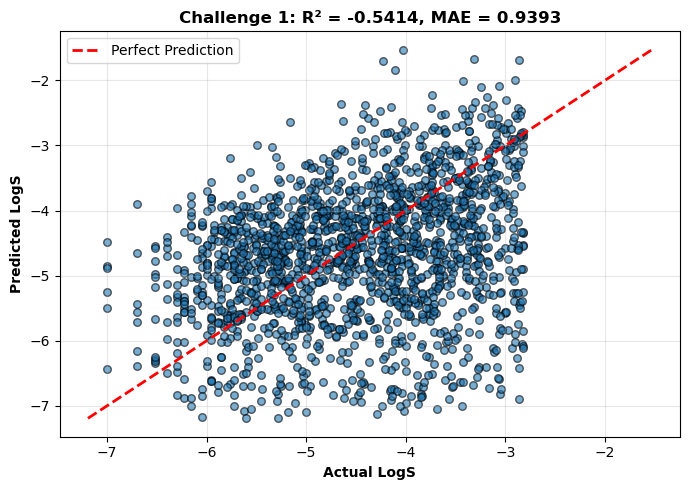

In [14]:
df_train = pd.read_csv(training_filename)

# Get feature column names (all columns after first 5)
feature_cols = df_train.columns[5:].tolist()

print(f"\n📋 Training model used {len(feature_cols)} features")
df1_descriptors = pd.read_csv(imputed_filename)
# Extract only the features that were used in training

missing = set(feature_cols) - set(df1_descriptors.columns)
print("Missing columns:", missing)

for col in missing:
    df1_descriptors[col] = 0

X1 = df1_descriptors[feature_cols]


# Get actual LogS values
y1_true = df1_descriptors['LogS'].values


print(f"\n✅ Features aligned!")
print(f"   Challenge 1 features: {X1.shape}")



try:
    model_rf = joblib.load(trained_model)
    print("\n✅ Model loaded successfully!")
except FileNotFoundError:
    print("\n❌ Error: Could not find 'random_forest_model.pkl'")
    print("Please make sure you saved your model in the RF training notebook using:")
    print("joblib.dump(model_rf, 'random_forest_model.pkl')")
    raise


y1_pred = model_rf.predict(X1)


print("\n✅ Predictions completed!")
print(f"   Challenge 1: {len(y1_pred)} predictions")


def evaluate_predictions(y_true, y_pred, dataset_name):
    """Calculate and print evaluation metrics"""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\n{'='*50}")
    print(f"📊 {dataset_name} EVALUATION")
    print(f"{'='*50}")
    print(f"R² Score:  {r2:.4f}")
    print(f"RMSE:      {rmse:.4f}")
    print(f"MAE:       {mae:.4f}")
    print(f"{'='*50}")
    
    return r2, rmse, mae

r2_1, rmse_1, mae_1 = evaluate_predictions(y1_true, y1_pred, "Challenge Data 1")


fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(y1_true, y1_pred, alpha=0.6, edgecolors='k', s=30)
min_val = min(y1_true.min(), y1_pred.min())
max_val = max(y1_true.max(), y1_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual LogS', fontweight='bold')
ax.set_ylabel('Predicted LogS', fontweight='bold')
ax.set_title(f'Challenge 1: R² = {r2_1:.4f}, MAE = {mae_1:.4f}', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [15]:
fig.tight_layout()
fig.savefig(image_name, dpi=300, bbox_inches='tight')
plt.show()
print("Figure Saved")



Figure Saved
